In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/Telco Customer Churn.csv


In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 1. Load Dataset
df = pd.read_csv('/kaggle/input/telco-customer-churn/Telco Customer Churn.csv')

# Basic info
print("Shape:", df.shape)
print("\nColumns:", df.columns)
df.head()

Shape: (7043, 21)

Columns: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# 2. Data Cleaning & Transformation
# Strip spaces from column names
df.columns = df.columns.str.strip()

In [6]:
# Convert TotalCharges to numeric and handle errors
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [7]:
# Check missing values
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [8]:
# Fill missing TotalCharges based on contract type
ind = df[df['TotalCharges'].isnull()].index.tolist()
for i in ind:
    if df.loc[i, 'Contract'] == 'Two year':
        df.loc[i, 'TotalCharges'] = max(df.loc[i, 'tenure'], 1) * df.loc[i, 'MonthlyCharges'] * 24
    elif df.loc[i, 'Contract'] == 'One year':
        df.loc[i, 'TotalCharges'] = max(df.loc[i, 'tenure'], 1) * df.loc[i, 'MonthlyCharges'] * 12
    else:
        df.loc[i, 'TotalCharges'] = max(df.loc[i, 'tenure'], 1) * df.loc[i, 'MonthlyCharges']


In [9]:
# Drop customerID as it's not required
df.drop('customerID', axis=1, inplace=True)

In [10]:
 # 3.Exploratory Data Analysis (EDA)
# Find the maximum number of months someone stayed (highest tenure)
max_tenure = df['tenure'].max()
print(f"Maximum number of months someone stayed: {max_tenure}")

Maximum number of months someone stayed: 72


In [11]:
# Count gender among highest tenure users
highest_tenure_users = df[df['tenure'] == max_tenure]
gender_count_highest_tenure = highest_tenure_users['gender'].value_counts()
print("\nGender count among highest tenure users:\n", gender_count_highest_tenure)



Gender count among highest tenure users:
 gender
Male      185
Female    177
Name: count, dtype: int64


In [12]:
#Find which gender has the highest average tenure
avg_tenure_gender = df.groupby('gender')['tenure'].mean()
print("\nAverage tenure by gender:\n", avg_tenure_gender)



Average tenure by gender:
 gender
Female    32.244553
Male      32.495359
Name: tenure, dtype: float64


In [13]:
#Which payment method is used the most?
payment_method_counts = df['PaymentMethod'].value_counts()
print("\nMost used payment method:\n", payment_method_counts)


Most used payment method:
 PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


In [14]:
#Which internet service type is most common?
internet_service_counts = df['InternetService'].value_counts()
print("\nMost common Internet Service type:\n", internet_service_counts)


Most common Internet Service type:
 InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64



Churn Rate by Payment Method (%):
 Churn                             No        Yes
PaymentMethod                                  
Bank transfer (automatic)  83.290155  16.709845
Credit card (automatic)    84.756899  15.243101
Electronic check           54.714588  45.285412
Mailed check               80.893300  19.106700


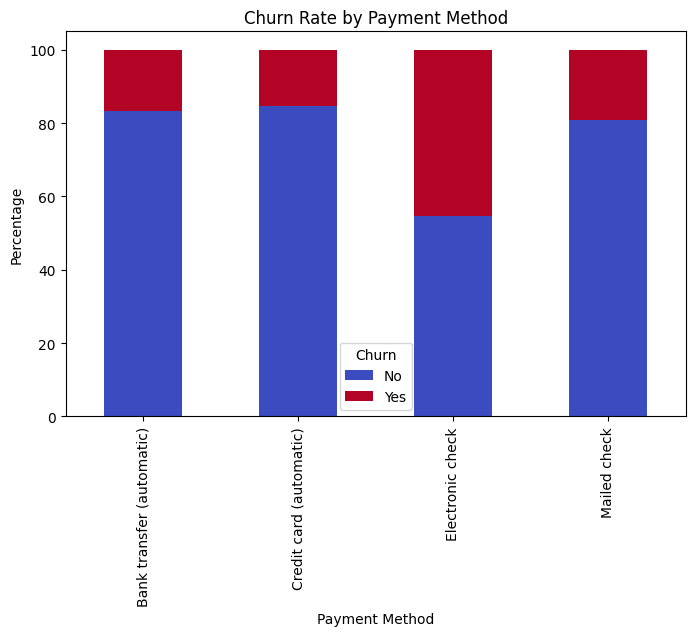

In [15]:
#Payment Method vs Churn Rate
churn_by_payment = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index') * 100
print("\nChurn Rate by Payment Method (%):\n", churn_by_payment)
churn_by_payment.plot(kind='bar', stacked=True, figsize=(8,5), colormap='coolwarm')
plt.title('Churn Rate by Payment Method')
plt.ylabel('Percentage')
plt.xlabel('Payment Method')
plt.legend(title='Churn')
plt.show()


Churn Rate by Internet Service (%):
 Churn                   No        Yes
InternetService                      
DSL              81.040892  18.959108
Fiber optic      58.107235  41.892765
No               92.595020   7.404980


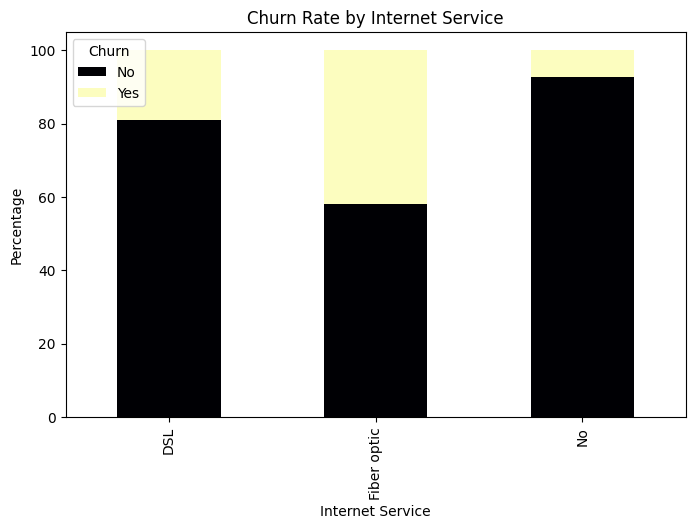

In [16]:
#Internet Service vs Churn Rate
churn_by_internet = pd.crosstab(df['InternetService'], df['Churn'], normalize='index') * 100
print("\nChurn Rate by Internet Service (%):\n", churn_by_internet)
churn_by_internet.plot(kind='bar', stacked=True, figsize=(8,5), colormap='magma')
plt.title('Churn Rate by Internet Service')
plt.ylabel('Percentage')
plt.xlabel('Internet Service')
plt.legend(title='Churn')
plt.show()


Churn Rate by Senior Citizen (%):
 Churn                 No        Yes
SeniorCitizen                      
0              76.393832  23.606168
1              58.318739  41.681261


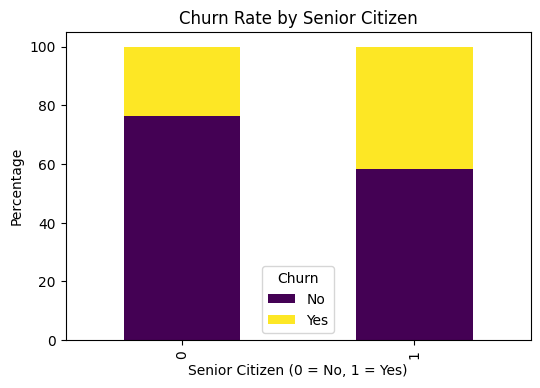

In [17]:
#Senior Citizen vs Churn Rate
churn_by_senior = pd.crosstab(df['SeniorCitizen'], df['Churn'], normalize='index') * 100
print("\nChurn Rate by Senior Citizen (%):\n", churn_by_senior)
churn_by_senior.plot(kind='bar', stacked=True, figsize=(6,4), colormap='viridis')
plt.title('Churn Rate by Senior Citizen')
plt.ylabel('Percentage')
plt.xlabel('Senior Citizen (0 = No, 1 = Yes)')
plt.legend(title='Churn')
plt.show()


Churn Rate by Contract Type (%):
 Churn                  No        Yes
Contract                            
Month-to-month  57.290323  42.709677
One year        88.730482  11.269518
Two year        97.168142   2.831858


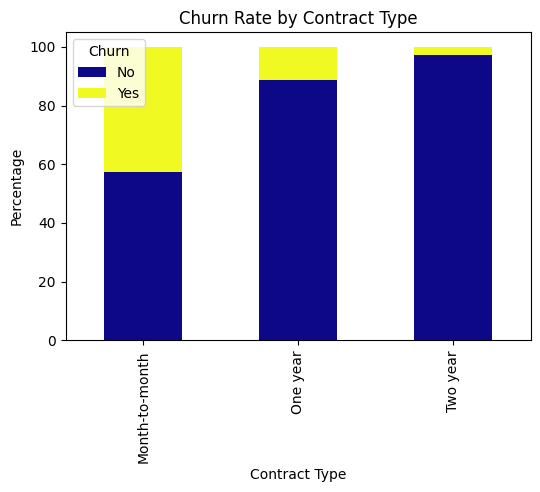

In [18]:
# Contract Type vs Churn Rate
churn_by_contract = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
print("\nChurn Rate by Contract Type (%):\n", churn_by_contract)
churn_by_contract.plot(kind='bar', stacked=True, figsize=(6,4), colormap='plasma')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Percentage')
plt.xlabel('Contract Type')
plt.legend(title='Churn')
plt.show()

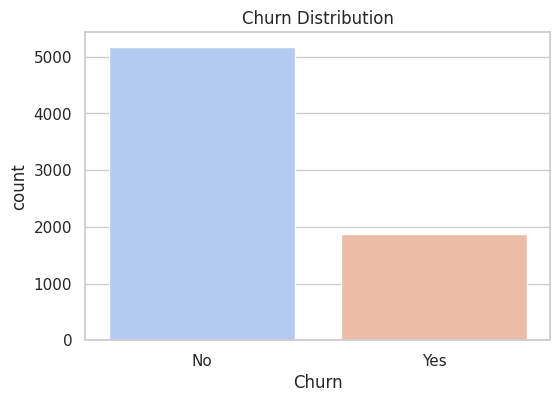

In [19]:
sns.set(style="whitegrid")
# Churn distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn', palette='coolwarm')
plt.title("Churn Distribution")
plt.show()

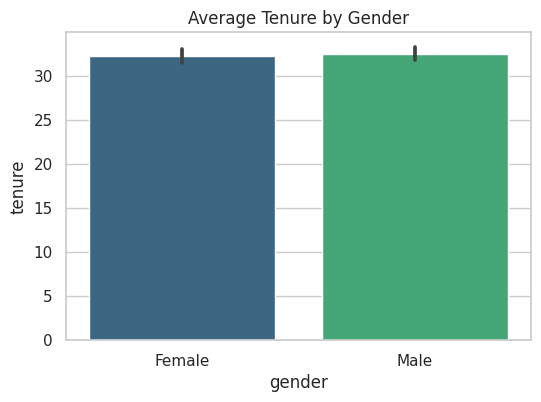

In [20]:
# Gender-wise average tenure (Your comparison)
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='gender', y='tenure', palette='viridis')
plt.title("Average Tenure by Gender")
plt.show()


Probability of Churn by Contract Type:
 Contract
Month-to-month    42.709677
One year          11.269518
Two year           2.831858
Name: Churn, dtype: float64


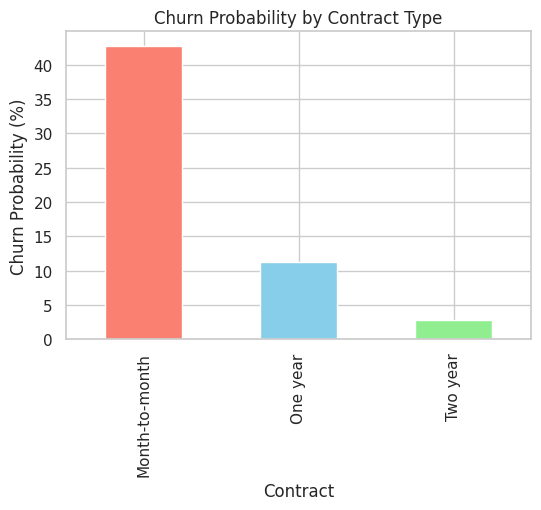

In [21]:
# Probability of churn by contract type
churn_prob = df.groupby('Contract')['Churn'].apply(lambda x: (x=='Yes').mean()*100)
print("\nProbability of Churn by Contract Type:\n", churn_prob)

churn_prob.plot(kind='bar', color=['salmon','skyblue','lightgreen'], figsize=(6,4))
plt.ylabel("Churn Probability (%)")
plt.title("Churn Probability by Contract Type")
plt.show()

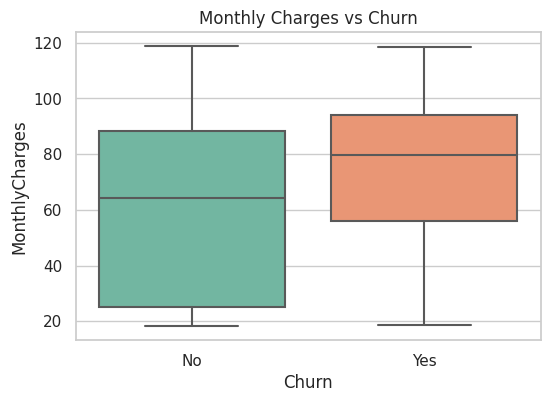

In [22]:
# Churn vs Monthly Charges
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette='Set2')
plt.title("Monthly Charges vs Churn")
plt.show()

In [23]:
# 4. Encoding Categorical Columns
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [24]:
# 5. Train-Test Split
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1035
           1       0.64      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



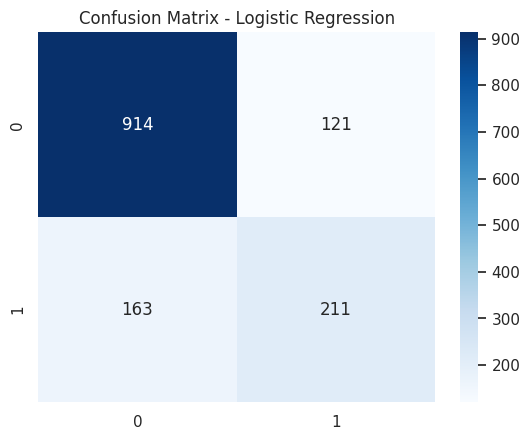


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



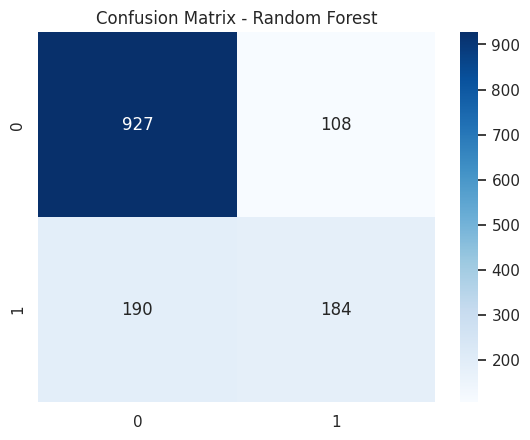


Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



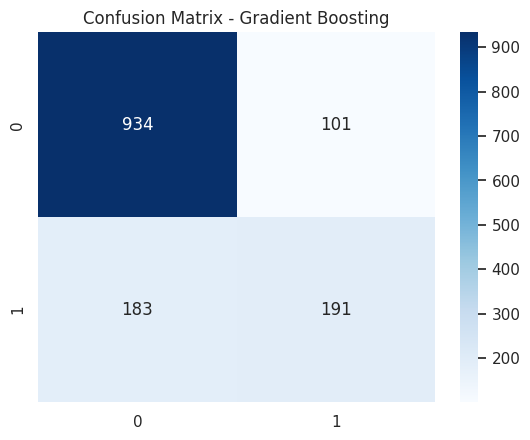

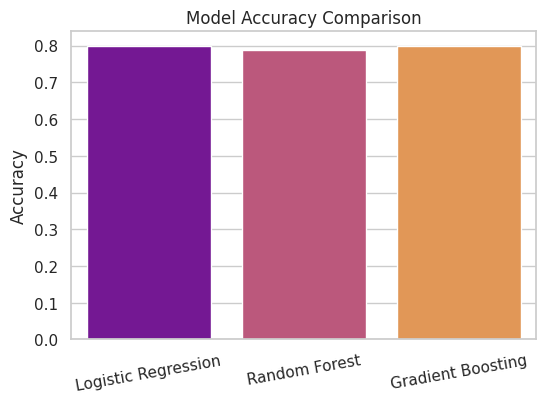


Best Performing Model: Logistic Regression with Accuracy: 0.80


In [25]:
# 6. Model Building & Evaluation

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

accuracy_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = acc
    
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Compare model accuracies
plt.figure(figsize=(6,4))
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette='plasma')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=10)
plt.show()

best_model = max(accuracy_scores, key=accuracy_scores.get)
print(f"\nBest Performing Model: {best_model} with Accuracy: {accuracy_scores[best_model]:.2f}")
